In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy
import cobra

# Bacillus

In [3]:
exometabolites_folder = Path("../../data/b_licheniformis/")
organism = 'b_licheniformis'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [4]:
gDW_per_OD = 0.32

In [5]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, organism)

In [6]:
df_OD = pd.read_csv(fn_OD, index_col=0)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,1.700,0.000000
1,1.745,0.007071
2,1.905,0.063640
3,2.080,0.042426
4,3.095,0.120208
5,4.235,0.007071
6,6.940,0.197990
7,9.735,0.035355
8,15.110,1.230366


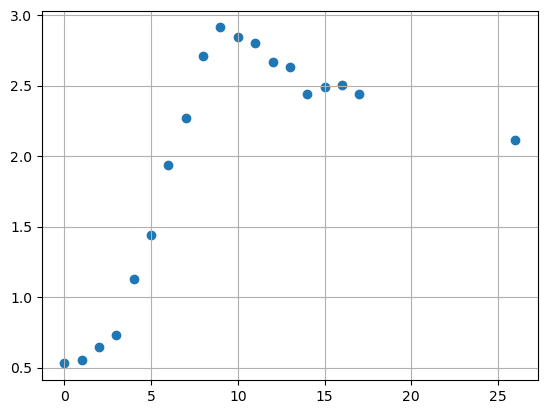

In [7]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()

# Estimate max glucose uptake rate
Answer = 5.3 mmol/gDW/h

In [28]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)

df_glucose = pd.read_csv(fn_glucose, index_col=0)
# df_glucose.loc[0,:]=[20,0] # From paper (in g/L)

In [29]:
cum_OD = np.zeros(19)*np.nan
for i in range(16):
    cum_OD[i+1] = scipy.integrate.simpson(df_OD.loc[1:i+1, 'OD mean'])

In [30]:
df_OD['Cum OD'] = cum_OD
df_OD['Cum OD gDW'] = df_OD['Cum OD']*gDW_per_OD
df_glucose['Glucose mM'] = df_glucose['Glucose mean']/180.18*1000

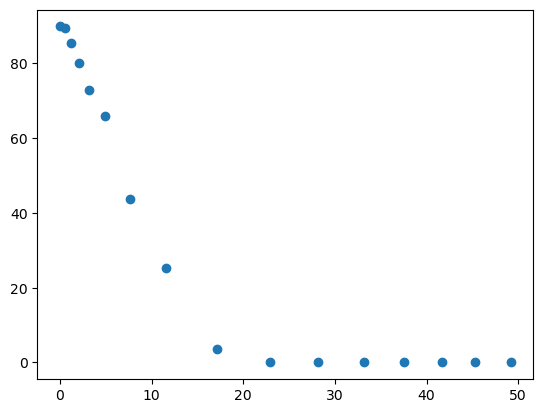

In [31]:
plt.scatter(df_OD['Cum OD gDW'], df_glucose['Glucose mM'])

In [35]:
df_OD.loc[1:9, 'Cum OD gDW']

Time
1     0.000000
2     0.584000
3     1.220800
4     2.026400
5     3.214933
6     4.961200
7     7.666133
8    11.572533
9    17.118400
Name: Cum OD gDW, dtype: float64

In [36]:
np.polyfit(df_OD.loc[1:9, 'Cum OD gDW'], df_glucose.loc[1:9, 'Glucose mM'], 1)

array([-5.31756481, 90.40147644])

## Mapping

In [118]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Bacillus metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [19]:
x = np.cumsum(df_OD['OD mean'])*gDW_per_OD

/Users/ssulheim/anaconda3/envs/pandas2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


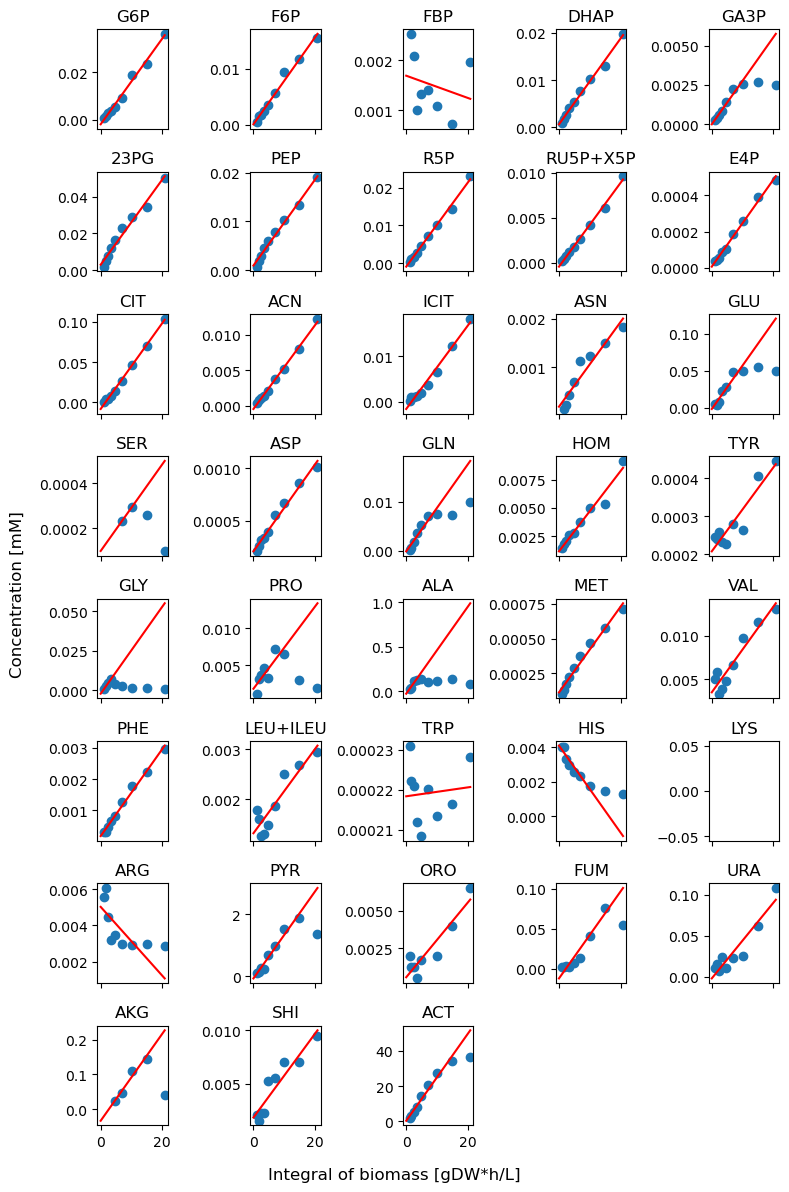

In [128]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (8, 12), sharex = True)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
max_idx = 9

for i,c in enumerate(concentrations.columns):
    conc = concentrations[c]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index <= max_idx
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (max_idx-1 in rate_conc.index) and (max_idx in rate_conc.index):
        if rate_conc[max_idx] < rate_conc[max_idx-1]:
            selection[max_idx] = False
            if rate_conc[max_idx-1] < rate_conc[max_idx-2]:
                selection[max_idx-1] = False
    # print(c)
    # print(conc[nan_idx&time_idx])
    if c in ['GA3P', 'GLU', 'GLN']:
        selection[max_idx] = False
        selection[max_idx-1] = False
    elif c in ['ACT']:
        selection[max_idx] = False
    elif c in ['GLY', 'ALA']:
        selection[5:] = False
        
    if len(conc[nan_idx&time_idx&selection]) >1:
        fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                                   conc[nan_idx&time_idx&selection],
                                                   full_output=True)
        rate_dict[c] = fit[0]
    else:
        rate_dict[c] = np.nan

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x[nan_idx&time_idx], conc[nan_idx&time_idx])
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c)

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.show()


In [23]:
rate_dict

{'G6P': 0.001815705613309207,
 'F6P': 0.0007798065891321033,
 'FBP': -2.2290233815899512e-05,
 'DHAP': 0.0009053751961758618,
 'GA3P': 0.0002777098353519472,
 '23PG': 0.0023269325323102743,
 'PEP': 0.0008793889391690532,
 'R5P': 0.0011145513920963609,
 'RU5P+X5P': 0.0004673899907093387,
 'E4P': 2.4006959064244546e-05,
 'CIT': 0.005347225038896686,
 'ACN': 0.0005908451959066858,
 'ICIT': 0.0009174293307948615,
 'ASN': 8.696520069241675e-05,
 'GLU': 0.005895708179699767,
 'SER': 1.938880328710837e-05,
 'ASP': 4.152096423713328e-05,
 'GLN': 0.0008890191989950809,
 'HOM': 0.00035491291273643735,
 'TYR': 1.1055345671723247e-05,
 'GLY': 0.002764901793985923,
 'PRO': 0.0005552994250440598,
 'ALA': 0.048921948060388645,
 'MET': 3.0751357864823025e-05,
 'VAL': 0.0004911718670588694,
 'PHE': 0.00013826590547265957,
 'LEU+ILEU': 8.442498026913601e-05,
 'TRP': 1.1168246633786874e-07,
 'HIS': -0.00025191027949105914,
 'LYS': nan,
 'ARG': -0.00019085248736203762,
 'PYR': 0.1407338295394529,
 'ORO': 

# Get model

In [96]:
# Couldn't get this model to work with reframed 
model_fn = '../../models/b_licheniformis/iBsu1147_irr_enz_constraint_adj.xml'
model_ez = cobra.io.read_sbml_model(model_fn)
# model = cobra.io.load_matlab_model('../../models/{0}/ec_iYO844.mat'.format(species))

model_ez.solver = 'gurobi'

In [119]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'{m_id}_c')

# Shadow prices

In [120]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    shadow_prices = leakage.estimate_shadow_prices(model_ez, delta=0.01, metabolites = measured_metabolites)

# Turnover

In [121]:
with model_ez as model:
    model.reactions.EX_glc__D_e.lower_bound = -5.3
    solution = cobra.flux_analysis.pfba(model)
turnover = {}
for m_id in measured_metabolites:
    m = model_ez.metabolites.get_by_id(m_id)
    turnover[m_id] = m.summary(solution).producing_flux['flux'].sum()

    

# Make spreadsheet

In [122]:
data = []
for abbr, rate in rate_dict.items():
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',')]
    rate = rate/len(bigg_ids)
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites.get_by_id(m_id)
        Nc = m.elements['C']
        mass = m.formula_weight
        
        data.append([bigg_id, name, rate, mv, turnover[m_id], Nc, mass])
df_rate = pd.DataFrame(data, columns = ['BiGG ID', 'Metabolite', 'Rate [mmol/gDW/h]', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]'])

In [124]:
df_rate['Species'] = 'B. licheniformis'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [125]:
df_rate.to_csv('paczia_13_rates_blicheniformis.csv')

In [126]:
df_rate

,BiGG ID,Metabolite,Rate [mmol/gDW/h],Metabolite value [gDW/mmol],Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Species,Carbon source,Dataset
0,g6p_A,Glucose-6-phosphate,1.815706e-03,0.081017,5.300000,6,259.127841,B. licheniformis,Glucose,Paczia-13
1,f6p_B,Fructose-6-phosphate,7.798066e-04,0.081019,5.198243,6,259.127841,B. licheniformis,Glucose,Paczia-13
2,fdp_B,"Fructose-1,6-bisphosphate",-2.229023e-05,0.086452,4.892308,6,338.099802,B. licheniformis,Glucose,Paczia-13
3,dhap,Dihydroxyacetonephosphate,9.053752e-04,0.043233,31.144644,3,169.049901,B. licheniformis,Glucose,Paczia-13
4,g3p,Glyceraldehyde-3-phosphate,2.777098e-04,0.043234,9.572013,3,169.049901,B. licheniformis,Glucose,Paczia-13
5,2pg,2/3-phosphoglycerate,1.163466e-03,0.034358,8.110630,3,184.041361,B. licheniformis,Glucose,Paczia-13
6,3pg,2/3-phosphoglycerate,1.163466e-03,0.034358,9.380940,3,184.041361,B. licheniformis,Glucose,Paczia-13
7,pep,Phosphoenolpyruvate,8.793889e-04,0.034411,8.110630,3,166.026081,B. licheniformis,Glucose,Paczia-13
8,r5p,Ribose-5-phosphate,1.114551e-03,0.068426,0.198572,5,229.101861,B. licheniformis,Glucose,Paczia-13
9,ru5p__D,Ribu-/Xylulose-5-phosphate,1.557967e-04,0.068425,0.173809,5,229.101861,B. licheniformis,Glucose,Paczia-13
